In [1]:
"""
RADAR SIGNAL PROCESSING TUTORIAL - Part 4
==========================================
CFAR Detection: Classical Algorithms (CA-CFAR & OS-CFAR)

Learning Objectives:
- Understand why fixed thresholds fail in radar detection
- Implement CA-CFAR (Cell-Averaging CFAR)
- Implement OS-CFAR (Ordered Statistics CFAR)
- Compare performance in different scenarios

Prerequisites: Parts 1-3 (RDM generation, noise characteristics)
Estimated time: 2-3 hours

Author's Note: This is a standalone tutorial. All RDM generation is self-contained.
"""

"\nRADAR SIGNAL PROCESSING TUTORIAL - Part 4\n==========================================\nCFAR Detection: Classical Algorithms (CA-CFAR & OS-CFAR)\n\nLearning Objectives:\n- Understand why fixed thresholds fail in radar detection\n- Implement CA-CFAR (Cell-Averaging CFAR)\n- Implement OS-CFAR (Ordered Statistics CFAR)\n- Compare performance in different scenarios\n\nPrerequisites: Parts 1-3 (RDM generation, noise characteristics)\nEstimated time: 2-3 hours\n\nAuthor's Note: This is a standalone tutorial. All RDM generation is self-contained.\n"

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from scipy.fft import fft2, fftshift
import warnings
import os
warnings.filterwarnings('ignore')

# Visualization setup
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Imports successful")
print("=" * 70)
print("PART 4: CFAR DETECTION - CLASSICAL ALGORITHMS")
print("=" * 70)

✓ Imports successful
PART 4: CFAR DETECTION - CLASSICAL ALGORITHMS


---
# Part 4: CFAR Detection - Classical Algorithms

## Quick Recap: Where We Are

From Parts 1-3, you understand:
- ✅ **Range-Doppler Map (RDM)**: 2D image showing targets at specific range and velocity
- ✅ **Noise**: Random variations that obscure weak targets
- ✅ **Clutter**: Strong returns from stationary objects (ground, buildings)
- ✅ **Micro-Doppler**: Helps classify what the target is (drone vs bird)

## The Next Challenge: Automatic Detection

**Human vs Computer:**
- YOU can look at an RDM and spot the bright spots (targets)
- But a computer needs an ALGORITHM to automatically find them

**This is what Part 4 solves: Constant False Alarm Rate (CFAR) Detection**

---
# 1. The Detection Problem: Why Fixed Thresholds Fail

## Core Concept: What is Detection?

**Detection = Making a binary decision for each cell in the RDM:**
```
If cell_value > threshold:
    Decision: "TARGET PRESENT" (Detection)
else:
    Decision: "NO TARGET" (Noise)
```

## Key Terms We'll Use (Explained Now):

**1. Threshold**: 
   - A cutoff value for decision making
   - Example: "If signal strength > 30 dB, declare target"
   - Units: Usually dB (decibels)

**2. dB (Decibel)**:
   - Logarithmic scale for power/amplitude
   - Formula: dB = 10 * log10(Power)
   - Why? Radar signals span huge ranges (1 to 1,000,000,000)
   - Example: 30 dB = 1000x power, 60 dB = 1,000,000x power

**3. SNR (Signal-to-Noise Ratio)**:
   - How much stronger is the signal than the noise?
   - SNR = Signal_Power / Noise_Power
   - In dB: SNR_dB = 10 * log10(Signal_Power / Noise_Power)
   - Example: SNR = 20 dB means signal is 100x stronger than noise

**4. Pfa (Probability of False Alarm)**:
   - Chance that noise alone triggers a detection
   - Example: Pfa = 1e-6 means 1 in a million noise-only cells will falsely detect
   - Lower Pfa = fewer false alarms, but might miss weak targets

**5. Pd (Probability of Detection)**:
   - Chance that a real target is detected
   - Example: Pd = 0.9 means we catch 90% of targets
   - Higher Pd = better, but usually causes higher Pfa

**6. RCS (Radar Cross Section)**:
   - How "reflective" a target is to radar
   - Units: square meters (m²)
   - Examples: Bird = 0.001 m², Drone = 0.01 m², Aircraft = 10 m²

## The Problem Illustrated

Imagine an RDM with:
- **Region A**: Clear sky, low noise floor (say, 10 dB)
- **Region B**: Near ground clutter, high noise floor (say, 50 dB)
- **Targets**: Weak drone at 15 dB in Region A, strong target at 55 dB in Region B

**If you set threshold = 30 dB:**
- ❌ Region A: Drone (15 dB) < 30 dB → MISSED DETECTION
- ❌ Region B: Many noise spikes (45-50 dB) > 30 dB → FALSE ALARMS

**If you set threshold = 20 dB:**
- ✓ Region A: Drone detected
- ❌ Region B: MASSIVE false alarms from clutter

**Conclusion: Fixed threshold CANNOT work because noise floor varies spatially!**

---

In [4]:
def create_synthetic_rdm(num_doppler=128, num_range=256, 
                         targets=None, noise_floor_db=-40, 
                         clutter_regions=None):
    """
    Generate a synthetic Range-Doppler Map for testing CFAR algorithms
    
    WHY THIS METHOD EXISTS:
    - Makes tutorial self-contained (don't need Part 2 code)
    - Full control over targets, noise, clutter for testing
    - Can create specific scenarios to prove algorithm behavior
    
    WHAT IT PROVES:
    - RDMs have spatially-varying noise floors
    - Clutter creates high-noise regions
    - Targets can be weak or strong relative to local noise
    
    Parameters:
    -----------
    num_doppler : int
        Number of Doppler (velocity) bins
    num_range : int
        Number of range bins
    targets : list of dict
        Each dict: {'range_bin': int, 'doppler_bin': int, 'snr_db': float}
        Example: {'range_bin': 100, 'doppler_bin': 64, 'snr_db': 15}
    noise_floor_db : float
        Base noise level in dB (default: -40 dB)
    clutter_regions : list of dict
        Each dict: {'range_start': int, 'range_end': int, 
                    'doppler_center': int, 'strength_db': float}
    
    Returns:
    --------
    rdm : ndarray
        Range-Doppler Map [num_doppler x num_range] in linear power scale
    rdm_db : ndarray
        Same RDM in dB scale (for visualization)
    ground_truth : ndarray
        Binary mask showing true target locations
    
    Educational Notes:
    ------------------
    - Noise floor: The average power level of noise in the RDM
    - Linear scale: Actual power values (e.g., 0.001, 1.0, 1000.0)
    - dB scale: Logarithmic (e.g., -30 dB, 0 dB, 30 dB) - easier to visualize
    - Ground truth: What we KNOW is true (for testing algorithm performance)
    """
    
    # Initialize with noise floor (convert dB to linear power)
    noise_linear = 10**(noise_floor_db / 10)
    
    # Create base noise (Rayleigh distributed - typical for radar)
    rdm = np.random.rayleigh(scale=np.sqrt(noise_linear/2), 
                             size=(num_doppler, num_range))
    
    # Ground truth mask (where targets actually are)
    ground_truth = np.zeros((num_doppler, num_range), dtype=bool)
    
    # Add clutter regions
    if clutter_regions is not None:
        for clutter in clutter_regions:
            r_start = clutter['range_start']
            r_end = clutter['range_end']
            d_center = clutter['doppler_center']
            strength_db = clutter['strength_db']
            
            clutter_linear = 10**(strength_db / 10)
            
            for d in range(num_doppler):
                doppler_profile = np.exp(-((d - d_center)**2) / (2 * 5**2))
                rdm[d, r_start:r_end] += clutter_linear * doppler_profile * \
                                          np.random.rand(r_end - r_start)
    
    # Add targets
    if targets is not None:
        for tgt in targets:
            r_bin = tgt['range_bin']
            d_bin = tgt['doppler_bin']
            snr_db = tgt['snr_db']
            
            local_noise = rdm[d_bin, r_bin]
            target_power = local_noise * 10**(snr_db / 10)
            
            # Add target (spread over 3x3 cells for realism)
            for dd in range(-1, 2):
                for dr in range(-1, 2):
                    d_idx = d_bin + dd
                    r_idx = r_bin + dr
                    if 0 <= d_idx < num_doppler and 0 <= r_idx < num_range:
                        spread = np.exp(-(dd**2 + dr**2) / 2)
                        rdm[d_idx, r_idx] += target_power * spread
                        if dd == 0 and dr == 0:
                            ground_truth[d_idx, r_idx] = True
    
    # Convert to dB for visualization
    rdm_db = 10 * np.log10(rdm + 1e-10)
    
    return rdm, rdm_db, ground_truth

In [7]:
def apply_fixed_threshold(rdm_db, threshold_db):
    """
    Apply a fixed threshold to RDM (the naive approach)
    
    WHY THIS METHOD EXISTS:
    - Demonstrate the baseline approach everyone tries first
    - Show WHY it fails (too many false alarms OR missed detections)
    - Motivate the need for adaptive thresholding (CFAR)
    """
    return rdm_db > threshold_db

In [8]:
def visualize_detection_problem(rdm_db, detections, ground_truth):
    """Visualize why fixed thresholds fail"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Original RDM
    im0 = axes[0].imshow(rdm_db, aspect='auto', cmap='jet', 
                         vmin=-50, vmax=10, origin='lower')
    axes[0].set_title('Range-Doppler Map (dB)', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Range Bin')
    axes[0].set_ylabel('Doppler Bin (Velocity)')
    plt.colorbar(im0, ax=axes[0], label='Power (dB)')
    
    gt_y, gt_x = np.where(ground_truth)
    axes[0].scatter(gt_x, gt_y, c='lime', s=200, marker='o', 
                   edgecolors='white', linewidths=2, label='True Targets')
    axes[0].legend(loc='upper right')
    
    # 2. Detections from fixed threshold
    axes[1].imshow(rdm_db, aspect='auto', cmap='gray', 
                   vmin=-50, vmax=10, origin='lower', alpha=0.5)
    
    det_y, det_x = np.where(detections)
    axes[1].scatter(det_x, det_y, c='red', s=50, marker='x', 
                   alpha=0.7, label='Fixed Threshold Detections')
    axes[1].scatter(gt_x, gt_y, c='lime', s=200, marker='o', 
                   edgecolors='white', linewidths=2, label='True Targets')
    axes[1].set_title('Fixed Threshold Detections', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Range Bin')
    axes[1].set_ylabel('Doppler Bin')
    axes[1].legend(loc='upper right')
    
    # 3. Error analysis
    true_positives = detections & ground_truth
    false_positives = detections & (~ground_truth)
    false_negatives = ground_truth & (~detections)
    
    axes[2].imshow(rdm_db, aspect='auto', cmap='gray', 
                   vmin=-50, vmax=10, origin='lower', alpha=0.3)
    
    tp_y, tp_x = np.where(true_positives)
    fp_y, fp_x = np.where(false_positives)
    fn_y, fn_x = np.where(false_negatives)
    
    axes[2].scatter(tp_x, tp_y, c='green', s=200, marker='o', 
                   label=f'Correct Detections ({len(tp_x)})', alpha=0.8)
    axes[2].scatter(fp_x, fp_y, c='red', s=50, marker='x', 
                   label=f'False Alarms ({len(fp_x)})', alpha=0.6)
    axes[2].scatter(fn_x, fn_y, c='yellow', s=200, marker='s', 
                   edgecolors='black', linewidths=2,
                   label=f'Missed Targets ({len(fn_x)})', alpha=0.8)
    
    axes[2].set_title('Detection Performance Analysis', fontweight='bold', fontsize=12)
    axes[2].set_xlabel('Range Bin')
    axes[2].set_ylabel('Doppler Bin')
    axes[2].legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n" + "=" * 60)
    print("FIXED THRESHOLD PERFORMANCE:")
    print("=" * 60)
    print(f"True Targets:        {np.sum(ground_truth)}")
    print(f"Correct Detections:  {np.sum(true_positives)} "
          f"({100*np.sum(true_positives)/max(1,np.sum(ground_truth)):.1f}%)")
    print(f"False Alarms:        {np.sum(false_positives)}")
    print(f"Missed Targets:      {np.sum(false_negatives)}")
    print("=" * 60)
    print("\n⚠️  Problem: Too many false alarms OR missed detections!")
    print("💡 Solution: CFAR adapts threshold to local noise level\n")


DEMONSTRATION: Fixed Threshold Failure

Creating synthetic RDM with:
  - Low-noise region (range 50-150): noise floor = -40 dB
  - High-noise region (range 0-50): strong clutter = -10 dB
  - 3 targets at different SNRs
✓ RDM created

Applying fixed threshold = -25 dB
✓ Detections computed

Visualizing results...


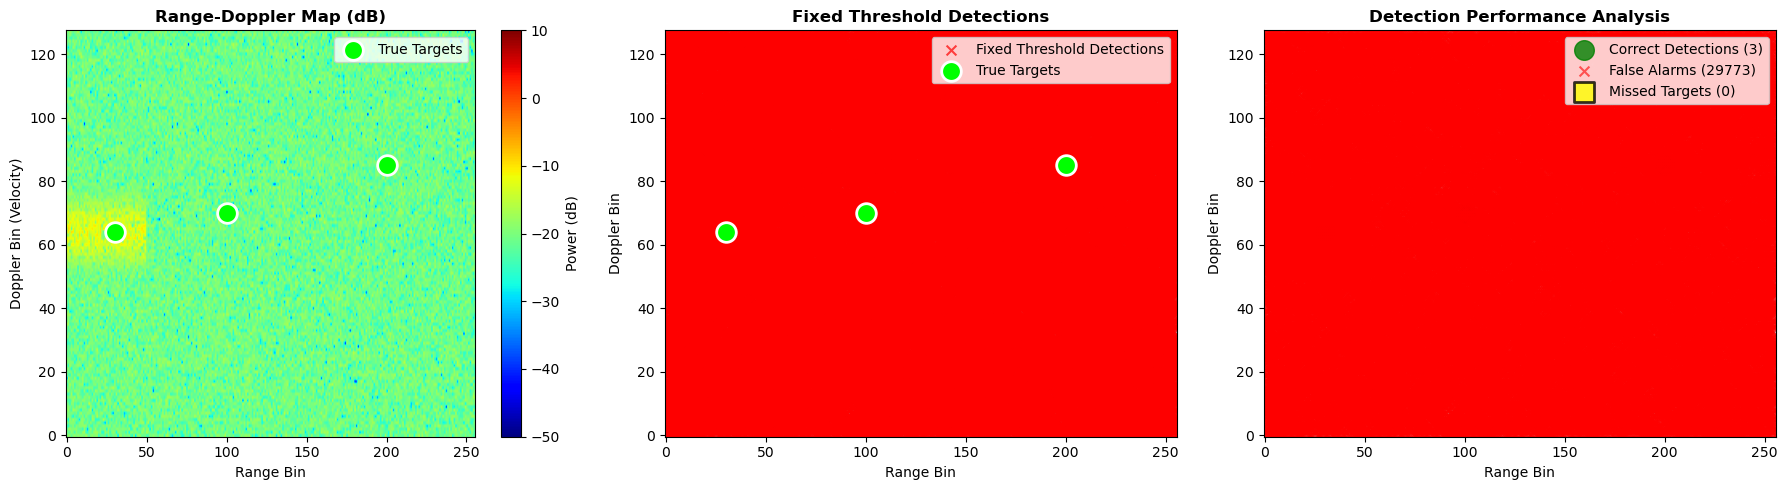


FIXED THRESHOLD PERFORMANCE:
True Targets:        3
Correct Detections:  3 (100.0%)
False Alarms:        29773
Missed Targets:      0

⚠️  Problem: Too many false alarms OR missed detections!
💡 Solution: CFAR adapts threshold to local noise level



In [9]:
print("\n" + "=" * 70)
print("DEMONSTRATION: Fixed Threshold Failure")
print("=" * 70)

# Create a challenging scenario
print("\nCreating synthetic RDM with:")
print("  - Low-noise region (range 50-150): noise floor = -40 dB")
print("  - High-noise region (range 0-50): strong clutter = -10 dB")
print("  - 3 targets at different SNRs")

targets = [
    {'range_bin': 100, 'doppler_bin': 70, 'snr_db': 12},
    {'range_bin': 200, 'doppler_bin': 85, 'snr_db': 20},
    {'range_bin': 30, 'doppler_bin': 64, 'snr_db': 15},
]

clutter = [
    {'range_start': 0, 'range_end': 50, 'doppler_center': 64, 'strength_db': -10}
]

rdm, rdm_db, ground_truth = create_synthetic_rdm(
    num_doppler=128, 
    num_range=256,
    targets=targets,
    noise_floor_db=-40,
    clutter_regions=clutter
)

print("✓ RDM created")

# Try fixed threshold
threshold_db = -25

print(f"\nApplying fixed threshold = {threshold_db} dB")
detections_fixed = apply_fixed_threshold(rdm_db, threshold_db)

print("✓ Detections computed")
print("\nVisualizing results...")

visualize_detection_problem(rdm_db, detections_fixed, ground_truth)

---
# 2. CA-CFAR: Cell-Averaging CFAR

## The Core Idea

**CFAR = Constant False Alarm Rate**

Instead of one global threshold, compute a DIFFERENT threshold for each cell:
1. Look at cells AROUND the test cell (the "training cells")
2. Estimate the noise level from those cells
3. Set threshold = (noise estimate) × (scale factor)
4. The scale factor is chosen to maintain constant Pfa

**Visual representation:**
```
+---+---+---+---+---+---+---+
| T | T | T | T | T | T | T |  ← Training cells (estimate noise)
+---+---+---+---+---+---+---+
| T | G | G | G | G | G | T |  G = Guard cells (don't use)
+---+---+---+---+---+---+---+
| T | G | X | X | X | G | T |  X = Test cell (decision point)
+---+---+---+---+---+---+---+
| T | G | G | G | G | G | T |
+---+---+---+---+---+---+---+
| T | T | T | T | T | T | T |
+---+---+---+---+---+---+---+
```

## Why Guard Cells?

If target is strong, it "leaks" into nearby cells. These would contaminate the
noise estimate, making threshold too high → miss the target!

---

In [10]:
def calculate_cfar_scale_factor(pfa, num_training_cells, distribution='rayleigh'):
    """Calculate the CFAR scale factor (threshold multiplier) from Pfa"""
    
    if pfa <= 0 or pfa >= 1:
        raise ValueError(f"Pfa must be between 0 and 1, got {pfa}")
    if num_training_cells < 1:
        raise ValueError(f"Number of training cells must be positive, got {num_training_cells}")
    
    N = num_training_cells
    
    if distribution == 'rayleigh':
        scale_factor = N * (pfa ** (-1.0 / N) - 1)
    elif distribution == 'exponential':
        scale_factor = -N * np.log(pfa)
    else:
        raise ValueError(f"Unknown distribution: {distribution}")
    
    return scale_factor

In [11]:
def ca_cfar_2d(rdm, guard_cells=2, training_cells=8, pfa=1e-6):
    """
    2D Cell-Averaging CFAR detector
    
    Parameters:
    -----------
    rdm : ndarray
        Range-Doppler Map in LINEAR power scale
    guard_cells : int
        Number of guard cells around test cell (each direction)
    training_cells : int
        Number of training cells beyond guard cells (each direction)
    pfa : float
        Desired probability of false alarm
        
    Returns:
    --------
    detections : ndarray (bool)
        Binary mask: True where target detected
    threshold_map : ndarray (float)
        The adaptive threshold at each cell
    """
    
    if rdm.ndim != 2:
        raise ValueError(f"RDM must be 2D array, got shape {rdm.shape}")
    
    num_doppler, num_range = rdm.shape
    total_window = guard_cells + training_cells
    
    # Calculate number of training cells
    full_window_size = (2 * total_window + 1) ** 2
    guard_window_size = (2 * guard_cells + 1) ** 2
    num_training = full_window_size - guard_window_size
    
    # Calculate scale factor
    scale_factor = calculate_cfar_scale_factor(pfa, num_training)
    
    print(f"CA-CFAR Configuration:")
    print(f"  Guard cells:     {guard_cells}")
    print(f"  Training cells:  {training_cells}")
    print(f"  Total window:    {2*total_window+1} × {2*total_window+1}")
    print(f"  Training count:  {num_training} cells")
    print(f"  Pfa:             {pfa:.2e}")
    print(f"  Scale factor:    {scale_factor:.3f}")
    
    # Initialize outputs
    detections = np.zeros((num_doppler, num_range), dtype=bool)
    threshold_map = np.zeros((num_doppler, num_range))
    
    # Process each cell
    for i in range(total_window, num_doppler - total_window):
        for j in range(total_window, num_range - total_window):
            
            # Extract window around test cell
            window = rdm[i - total_window : i + total_window + 1,
                        j - total_window : j + total_window + 1]
            
            # Create mask for training cells
            mask = np.ones_like(window, dtype=bool)
            
            # Mask out guard region
            guard_start = training_cells
            guard_end = training_cells + 2 * guard_cells + 1
            mask[guard_start:guard_end, guard_start:guard_end] = False
            
            # Extract training cells
            training_samples = window[mask]
            
            # Estimate local noise level (average of training cells)
            noise_estimate = np.mean(training_samples)
            
            # Adaptive threshold
            threshold = noise_estimate * scale_factor
            threshold_map[i, j] = threshold
            
            # Detection test
            if rdm[i, j] > threshold:
                detections[i, j] = True
    
    return detections, threshold_map


DEMONSTRATION: CA-CFAR in Action

Applying CA-CFAR detector...
  (This may take 10-30 seconds for full RDM)
CA-CFAR Configuration:
  Guard cells:     2
  Training cells:  6
  Total window:    17 × 17
  Training count:  264 cells
  Pfa:             1.00e-05
  Scale factor:    11.768
✓ CA-CFAR detection complete


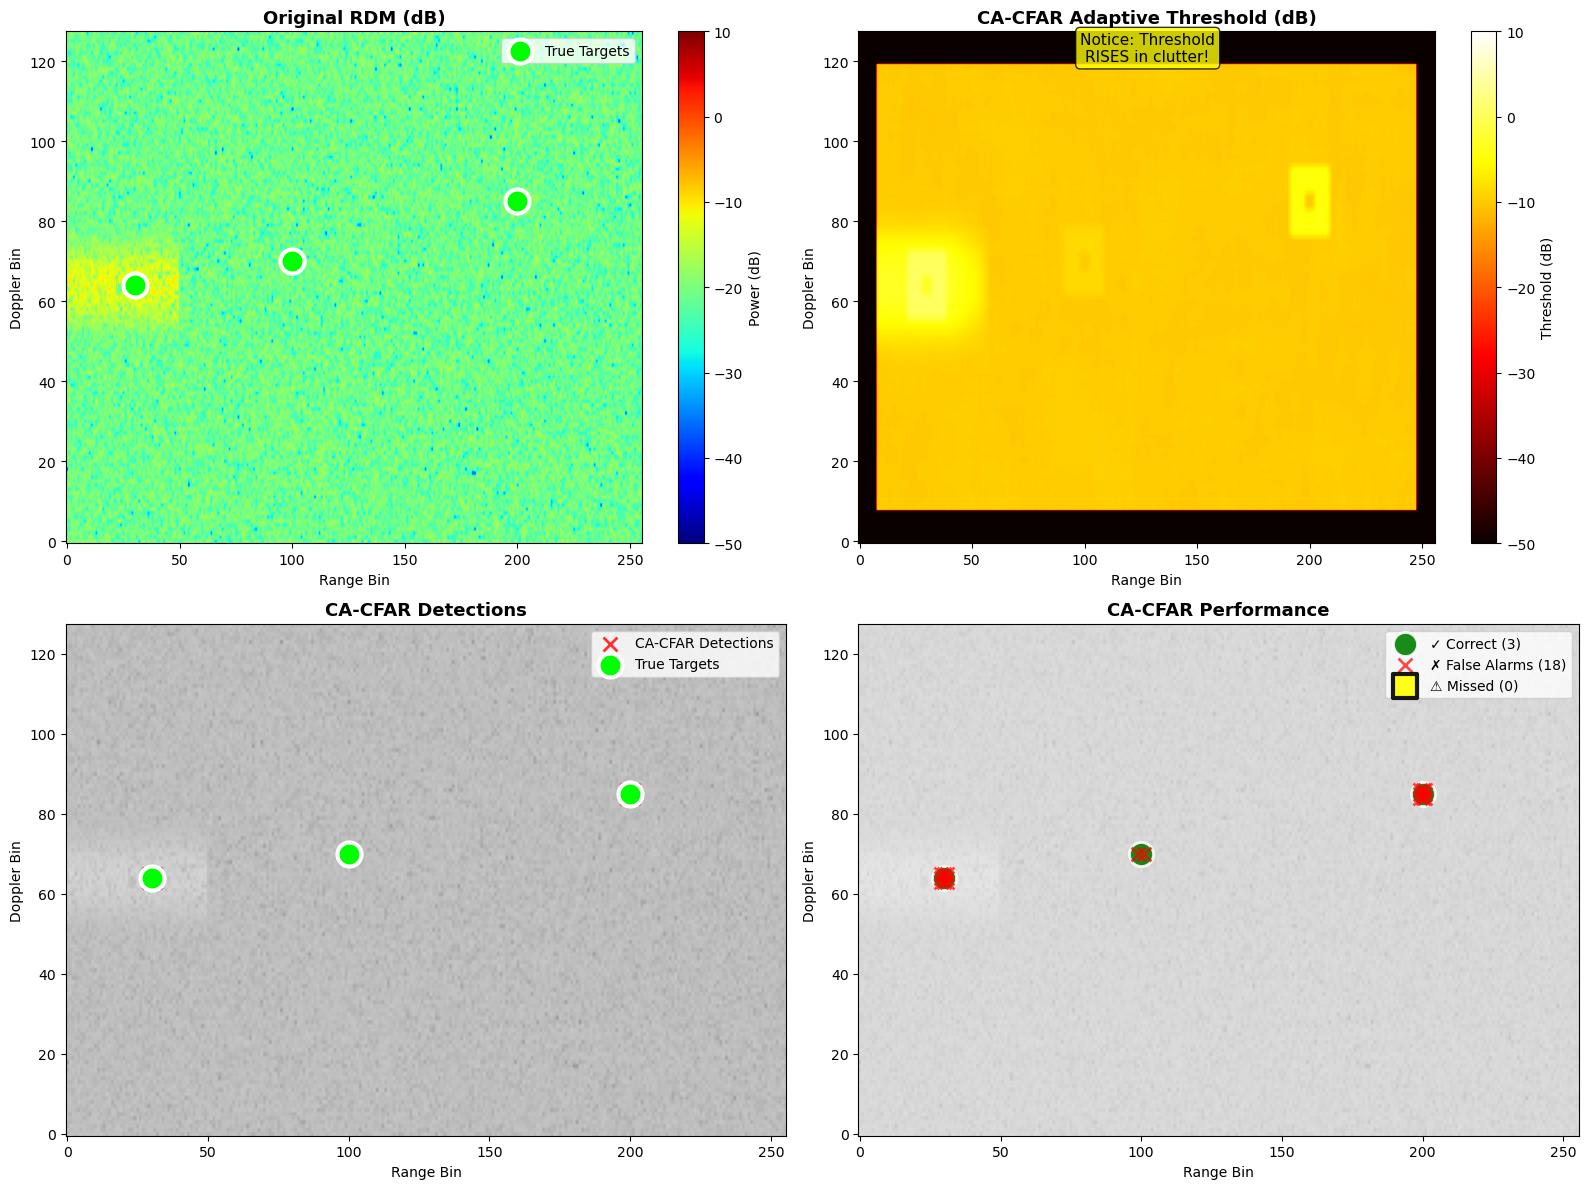


CA-CFAR PERFORMANCE ANALYSIS:
True Targets:        3
CA-CFAR Detections:  21
  ├─ Correct:        3 (100.0%)
  ├─ False Alarms:   18
  └─ Missed:         0

💡 Key Observation:
   Notice how the threshold ADAPTS - high in clutter, low in clear regions!
   This is why CFAR works where fixed thresholds fail.


In [12]:
print("\n" + "=" * 70)
print("DEMONSTRATION: CA-CFAR in Action")
print("=" * 70)

# Use same RDM from before
rdm_linear = 10 ** (rdm_db / 10)

print("\nApplying CA-CFAR detector...")
print("  (This may take 10-30 seconds for full RDM)")

detections_ca, threshold_ca = ca_cfar_2d(
    rdm_linear,
    guard_cells=2,
    training_cells=6,
    pfa=1e-5
)

print("✓ CA-CFAR detection complete")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Original RDM
im0 = axes[0, 0].imshow(rdm_db, aspect='auto', cmap='jet', 
                        vmin=-50, vmax=10, origin='lower')
axes[0, 0].set_title('Original RDM (dB)', fontweight='bold', fontsize=13)
axes[0, 0].set_xlabel('Range Bin')
axes[0, 0].set_ylabel('Doppler Bin')
plt.colorbar(im0, ax=axes[0, 0], label='Power (dB)')

gt_y, gt_x = np.where(ground_truth)
axes[0, 0].scatter(gt_x, gt_y, c='lime', s=300, marker='o', 
                  edgecolors='white', linewidths=3, label='True Targets')
axes[0, 0].legend(loc='upper right', fontsize=10)

# 2. Adaptive threshold map
threshold_db = 10 * np.log10(threshold_ca + 1e-10)
im1 = axes[0, 1].imshow(threshold_db, aspect='auto', cmap='hot', 
                        vmin=-50, vmax=10, origin='lower')
axes[0, 1].set_title('CA-CFAR Adaptive Threshold (dB)', fontweight='bold', fontsize=13)
axes[0, 1].set_xlabel('Range Bin')
axes[0, 1].set_ylabel('Doppler Bin')
plt.colorbar(im1, ax=axes[0, 1], label='Threshold (dB)')
axes[0, 1].text(128, 120, 'Notice: Threshold\nRISES in clutter!', 
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
               fontsize=11, ha='center')

# 3. CA-CFAR detections
axes[1, 0].imshow(rdm_db, aspect='auto', cmap='gray', 
                  vmin=-50, vmax=10, origin='lower', alpha=0.5)
det_y, det_x = np.where(detections_ca)
axes[1, 0].scatter(det_x, det_y, c='red', s=100, marker='x', 
                  alpha=0.8, linewidths=2, label='CA-CFAR Detections')
axes[1, 0].scatter(gt_x, gt_y, c='lime', s=300, marker='o', 
                  edgecolors='white', linewidths=3, label='True Targets')
axes[1, 0].set_title('CA-CFAR Detections', fontweight='bold', fontsize=13)
axes[1, 0].set_xlabel('Range Bin')
axes[1, 0].set_ylabel('Doppler Bin')
axes[1, 0].legend(loc='upper right', fontsize=10)

# 4. Performance analysis
true_positives = detections_ca & ground_truth
false_positives = detections_ca & (~ground_truth)
false_negatives = ground_truth & (~detections_ca)

axes[1, 1].imshow(rdm_db, aspect='auto', cmap='gray', 
                  vmin=-50, vmax=10, origin='lower', alpha=0.3)

tp_y, tp_x = np.where(true_positives)
fp_y, fp_x = np.where(false_positives)
fn_y, fn_x = np.where(false_negatives)

axes[1, 1].scatter(tp_x, tp_y, c='green', s=300, marker='o', 
                  label=f'✓ Correct ({len(tp_x)})', alpha=0.9, linewidths=2, 
                  edgecolors='white')
axes[1, 1].scatter(fp_x, fp_y, c='red', s=100, marker='x', 
                  label=f'✗ False Alarms ({len(fp_x)})', alpha=0.7, linewidths=2)
axes[1, 1].scatter(fn_x, fn_y, c='yellow', s=300, marker='s', 
                  edgecolors='black', linewidths=3,
                  label=f'⚠ Missed ({len(fn_x)})', alpha=0.9)

axes[1, 1].set_title('CA-CFAR Performance', fontweight='bold', fontsize=13)
axes[1, 1].set_xlabel('Range Bin')
axes[1, 1].set_ylabel('Doppler Bin')
axes[1, 1].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "=" * 70)
print("CA-CFAR PERFORMANCE ANALYSIS:")
print("=" * 70)
print(f"True Targets:        {np.sum(ground_truth)}")
print(f"CA-CFAR Detections:  {np.sum(detections_ca)}")
print(f"  ├─ Correct:        {np.sum(true_positives)} "
      f"({100*np.sum(true_positives)/max(1,np.sum(ground_truth)):.1f}%)")
print(f"  ├─ False Alarms:   {np.sum(false_positives)}")
print(f"  └─ Missed:         {np.sum(false_negatives)}")
print("=" * 70)

print("\n💡 Key Observation:")
print("   Notice how the threshold ADAPTS - high in clutter, low in clear regions!")
print("   This is why CFAR works where fixed thresholds fail.")

---
# 3. OS-CFAR: Ordered Statistics CFAR

## When CA-CFAR Fails: The Clutter Edge Problem

**Scenario:**
Test cell is in clear region, but training window is half clutter, half clear.

**What happens with CA-CFAR:**
1. Average training cells = (high + low) / 2 = MEDIUM
2. Threshold = MEDIUM × scale_factor
3. But actual noise at test cell is LOW
4. Result: Threshold TOO HIGH → MISSED DETECTION

## OS-CFAR Solution: Use Order Statistics

**Key Idea:** Instead of MEAN (sensitive to outliers), use PERCENTILE

- Median (50th percentile) is robust to outliers
- Typical: 75th percentile - rejects upper 25% outliers

---

In [13]:
def os_cfar_2d(rdm, guard_cells=2, training_cells=8, k_percentile=75, pfa=1e-6):
    """
    2D Ordered Statistics CFAR detector
    
    Parameters:
    -----------
    rdm : ndarray
        Range-Doppler Map in LINEAR power scale
    guard_cells : int
        Number of guard cells
    training_cells : int
        Number of training cells
    k_percentile : float
        Which percentile to use (50-90 typical)
    pfa : float
        Desired probability of false alarm
    
    Returns:
    --------
    detections : ndarray (bool)
    threshold_map : ndarray (float)
    """
    
    if rdm.ndim != 2:
        raise ValueError(f"RDM must be 2D array, got shape {rdm.shape}")
    
    num_doppler, num_range = rdm.shape
    total_window = guard_cells + training_cells
    
    # Calculate number of training cells
    full_window_size = (2 * total_window + 1) ** 2
    guard_window_size = (2 * guard_cells + 1) ** 2
    num_training = full_window_size - guard_window_size
    
    scale_factor = calculate_cfar_scale_factor(pfa, num_training)
    
    print(f"OS-CFAR Configuration:")
    print(f"  Guard cells:     {guard_cells}")
    print(f"  Training cells:  {training_cells}")
    print(f"  k-percentile:    {k_percentile}%")
    print(f"  Training count:  {num_training} cells")
    print(f"  Pfa:             {pfa:.2e}")
    print(f"  Scale factor:    {scale_factor:.3f}")
    
    # Initialize outputs
    detections = np.zeros((num_doppler, num_range), dtype=bool)
    threshold_map = np.zeros((num_doppler, num_range))
    
    # Process each cell
    for i in range(total_window, num_doppler - total_window):
        for j in range(total_window, num_range - total_window):
            
            window = rdm[i - total_window : i + total_window + 1,
                        j - total_window : j + total_window + 1]
            
            mask = np.ones_like(window, dtype=bool)
            guard_start = training_cells
            guard_end = training_cells + 2 * guard_cells + 1
            mask[guard_start:guard_end, guard_start:guard_end] = False
            
            training_samples = window[mask]
            
            # DIFFERENCE FROM CA-CFAR: Use percentile instead of mean
            noise_estimate = np.percentile(training_samples, k_percentile)
            
            threshold = noise_estimate * scale_factor
            threshold_map[i, j] = threshold
            
            if rdm[i, j] > threshold:
                detections[i, j] = True
    
    return detections, threshold_map

In [14]:
def create_clutter_edge_scenario():
    """Create scenario to show OS-CFAR superiority at clutter edges"""
    
    print("\nCreating CLUTTER EDGE scenario:")
    print("  - Sharp boundary: clutter (range 0-80) → clear (range 80+)")
    print("  - Target at edge (range 85) - where CA-CFAR fails!")
    
    targets = [
        {'range_bin': 85, 'doppler_bin': 64, 'snr_db': 15},  # Right at edge
        {'range_bin': 95, 'doppler_bin': 70, 'snr_db': 12},  # Beyond edge
        {'range_bin': 180, 'doppler_bin': 80, 'snr_db': 18}, # Far from clutter
    ]
    
    clutter = [
        {'range_start': 0, 'range_end': 80, 'doppler_center': 64, 'strength_db': -5}
    ]
    
    rdm, rdm_db, ground_truth = create_synthetic_rdm(
        num_doppler=128,
        num_range=256,
        targets=targets,
        noise_floor_db=-40,
        clutter_regions=clutter
    )
    
    return rdm, rdm_db, ground_truth


DEMONSTRATION: CA-CFAR vs OS-CFAR at Clutter Edge

Creating CLUTTER EDGE scenario:
  - Sharp boundary: clutter (range 0-80) → clear (range 80+)
  - Target at edge (range 85) - where CA-CFAR fails!

✓ Scenario created

Applying CA-CFAR...
CA-CFAR Configuration:
  Guard cells:     2
  Training cells:  6
  Total window:    17 × 17
  Training count:  264 cells
  Pfa:             1.00e-05
  Scale factor:    11.768

Applying OS-CFAR...
OS-CFAR Configuration:
  Guard cells:     2
  Training cells:  6
  k-percentile:    75%
  Training count:  264 cells
  Pfa:             1.00e-05
  Scale factor:    11.768

✓ Both detectors applied


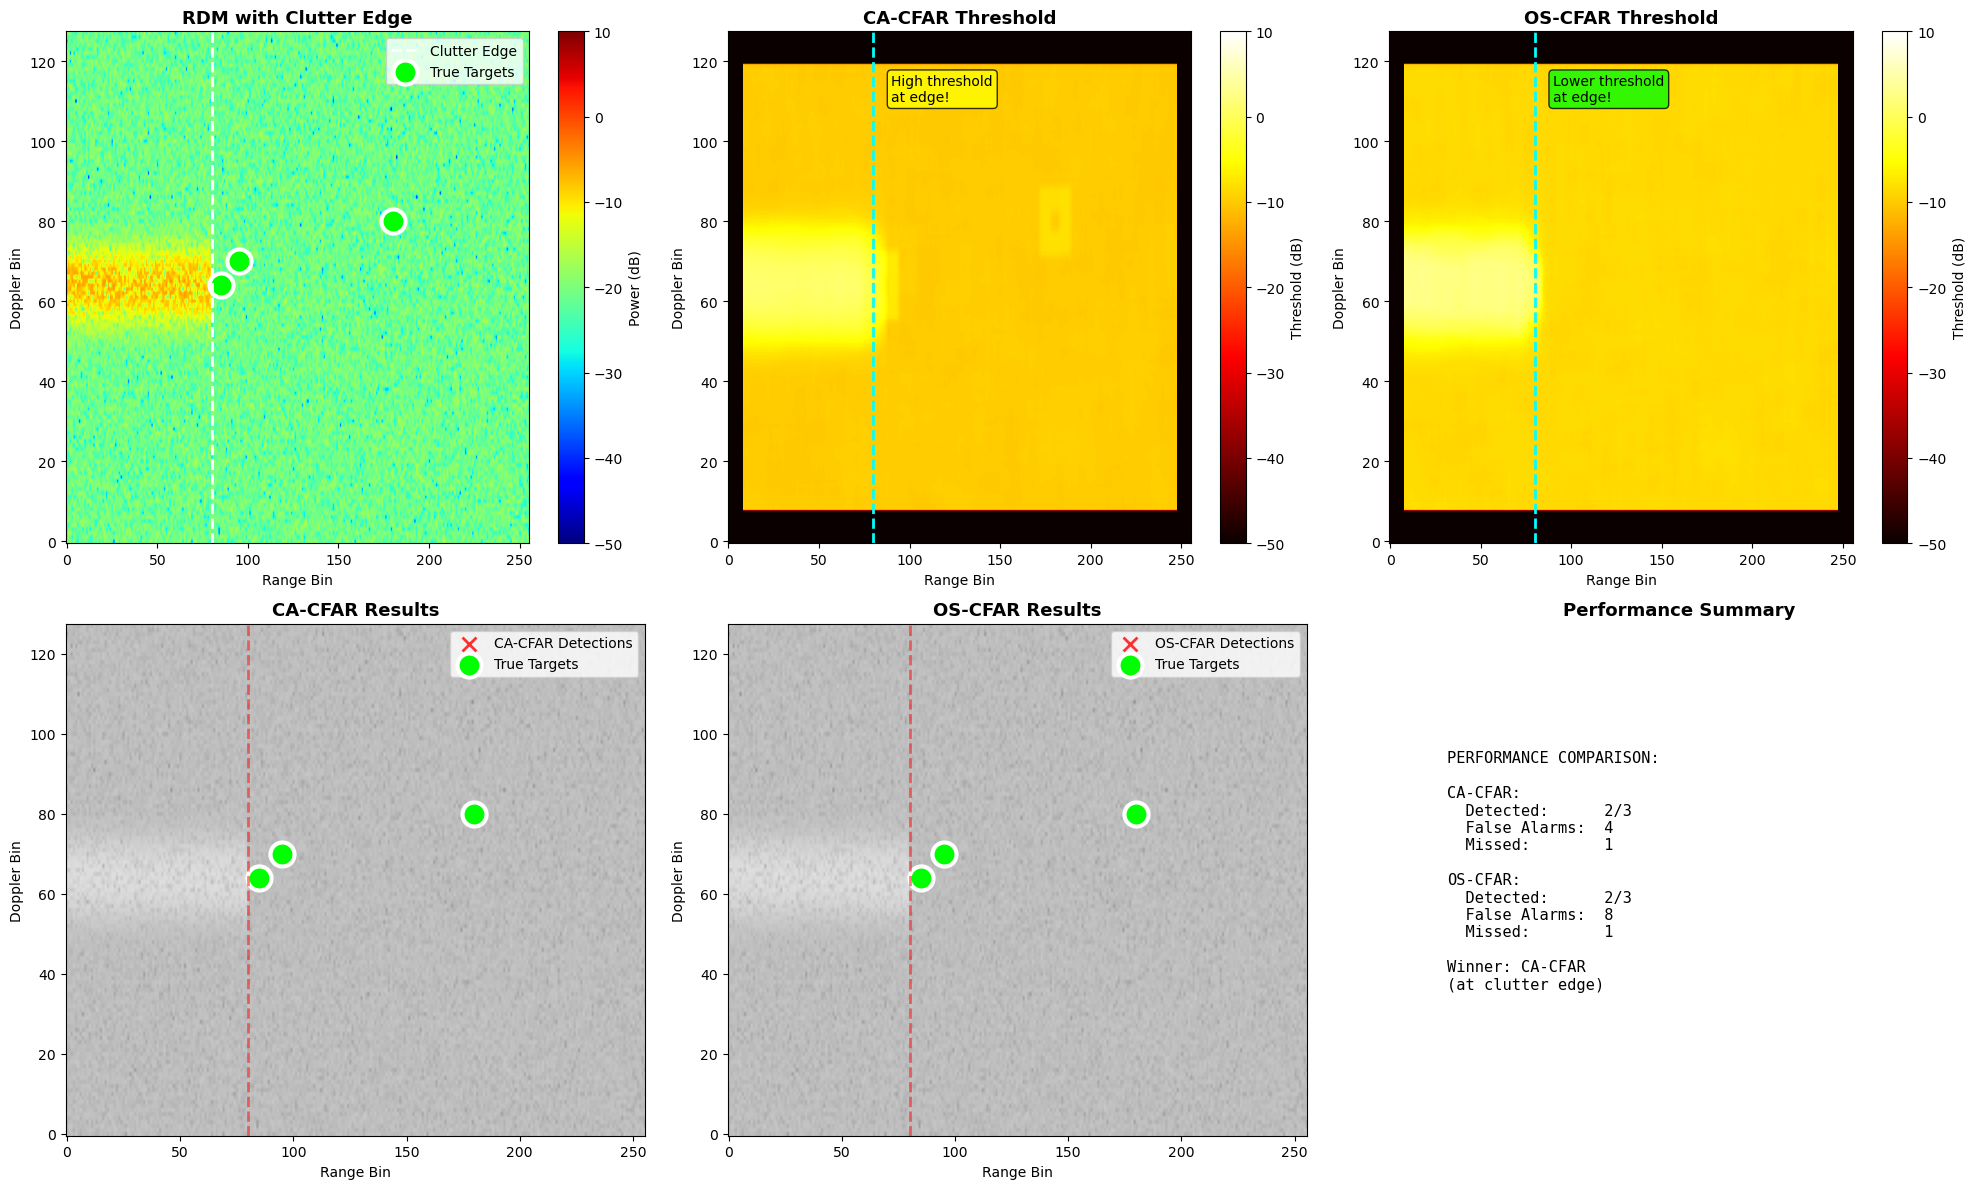


CLUTTER EDGE PERFORMANCE:

CA-CFAR:
  Detected:      2/3 targets
  False Alarms:  4
  Missed:        1

OS-CFAR:
  Detected:      2/3 targets
  False Alarms:  8
  Missed:        1

🤝 TIE - Both performed equally well

💡 Key Insight:
   OS-CFAR uses median/percentile → ignores clutter outliers
   CA-CFAR uses mean → pulled up by clutter → threshold too high


In [15]:
print("\n" + "=" * 70)
print("DEMONSTRATION: CA-CFAR vs OS-CFAR at Clutter Edge")
print("=" * 70)

# Create clutter edge scenario
rdm_edge, rdm_edge_db, gt_edge = create_clutter_edge_scenario()
rdm_edge_linear = 10 ** (rdm_edge_db / 10)

print("\n✓ Scenario created")

# Apply both detectors
print("\nApplying CA-CFAR...")
det_ca_edge, thresh_ca_edge = ca_cfar_2d(
    rdm_edge_linear,
    guard_cells=2,
    training_cells=6,
    pfa=1e-5
)

print("\nApplying OS-CFAR...")
det_os_edge, thresh_os_edge = os_cfar_2d(
    rdm_edge_linear,
    guard_cells=2,
    training_cells=6,
    k_percentile=75,
    pfa=1e-5
)

print("\n✓ Both detectors applied")

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Original RDM
im0 = axes[0, 0].imshow(rdm_edge_db, aspect='auto', cmap='jet',
                        vmin=-50, vmax=10, origin='lower')
axes[0, 0].set_title('RDM with Clutter Edge', fontweight='bold', fontsize=13)
axes[0, 0].set_xlabel('Range Bin')
axes[0, 0].set_ylabel('Doppler Bin')
axes[0, 0].axvline(80, color='white', linestyle='--', linewidth=2, label='Clutter Edge')
plt.colorbar(im0, ax=axes[0, 0], label='Power (dB)')

gt_y, gt_x = np.where(gt_edge)
axes[0, 0].scatter(gt_x, gt_y, c='lime', s=300, marker='o',
                  edgecolors='white', linewidths=3, label='True Targets')
axes[0, 0].legend(loc='upper right')

# 2. CA-CFAR threshold
thresh_ca_db = 10 * np.log10(thresh_ca_edge + 1e-10)
im1 = axes[0, 1].imshow(thresh_ca_db, aspect='auto', cmap='hot',
                        vmin=-50, vmax=10, origin='lower')
axes[0, 1].set_title('CA-CFAR Threshold', fontweight='bold', fontsize=13)
axes[0, 1].set_xlabel('Range Bin')
axes[0, 1].set_ylabel('Doppler Bin')
axes[0, 1].axvline(80, color='cyan', linestyle='--', linewidth=2)
plt.colorbar(im1, ax=axes[0, 1], label='Threshold (dB)')
axes[0, 1].text(90, 110, 'High threshold\nat edge!',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
               fontsize=10)

# 3. OS-CFAR threshold
thresh_os_db = 10 * np.log10(thresh_os_edge + 1e-10)
im2 = axes[0, 2].imshow(thresh_os_db, aspect='auto', cmap='hot',
                        vmin=-50, vmax=10, origin='lower')
axes[0, 2].set_title('OS-CFAR Threshold', fontweight='bold', fontsize=13)
axes[0, 2].set_xlabel('Range Bin')
axes[0, 2].set_ylabel('Doppler Bin')
axes[0, 2].axvline(80, color='cyan', linestyle='--', linewidth=2)
plt.colorbar(im2, ax=axes[0, 2], label='Threshold (dB)')
axes[0, 2].text(90, 110, 'Lower threshold\nat edge!',
               bbox=dict(boxstyle='round', facecolor='lime', alpha=0.8),
               fontsize=10)

# 4. CA-CFAR detections
axes[1, 0].imshow(rdm_edge_db, aspect='auto', cmap='gray',
                  vmin=-50, vmax=10, origin='lower', alpha=0.5)
axes[1, 0].axvline(80, color='red', linestyle='--', linewidth=2, alpha=0.5)

det_ca_y, det_ca_x = np.where(det_ca_edge)
axes[1, 0].scatter(det_ca_x, det_ca_y, c='red', s=100, marker='x',
                  alpha=0.8, linewidths=2, label='CA-CFAR Detections')
axes[1, 0].scatter(gt_x, gt_y, c='lime', s=300, marker='o',
                  edgecolors='white', linewidths=3, label='True Targets')
axes[1, 0].set_title('CA-CFAR Results', fontweight='bold', fontsize=13)
axes[1, 0].set_xlabel('Range Bin')
axes[1, 0].set_ylabel('Doppler Bin')
axes[1, 0].legend(loc='upper right')

# 5. OS-CFAR detections
axes[1, 1].imshow(rdm_edge_db, aspect='auto', cmap='gray',
                  vmin=-50, vmax=10, origin='lower', alpha=0.5)
axes[1, 1].axvline(80, color='red', linestyle='--', linewidth=2, alpha=0.5)

det_os_y, det_os_x = np.where(det_os_edge)
axes[1, 1].scatter(det_os_x, det_os_y, c='red', s=100, marker='x',
                  alpha=0.8, linewidths=2, label='OS-CFAR Detections')
axes[1, 1].scatter(gt_x, gt_y, c='lime', s=300, marker='o',
                  edgecolors='white', linewidths=3, label='True Targets')
axes[1, 1].set_title('OS-CFAR Results', fontweight='bold', fontsize=13)
axes[1, 1].set_xlabel('Range Bin')
axes[1, 1].set_ylabel('Doppler Bin')
axes[1, 1].legend(loc='upper right')

# 6. Performance comparison
tp_ca = det_ca_edge & gt_edge
fp_ca = det_ca_edge & (~gt_edge)
fn_ca = gt_edge & (~det_ca_edge)

tp_os = det_os_edge & gt_edge
fp_os = det_os_edge & (~gt_edge)
fn_os = gt_edge & (~det_os_edge)

comparison_text = f"""PERFORMANCE COMPARISON:

CA-CFAR:
  Detected:      {np.sum(tp_ca)}/{np.sum(gt_edge)}
  False Alarms:  {np.sum(fp_ca)}
  Missed:        {np.sum(fn_ca)}

OS-CFAR:
  Detected:      {np.sum(tp_os)}/{np.sum(gt_edge)}
  False Alarms:  {np.sum(fp_os)}
  Missed:        {np.sum(fn_os)}

Winner: {'OS-CFAR' if np.sum(tp_os) > np.sum(tp_ca) else 'CA-CFAR'}
(at clutter edge)
"""

axes[1, 2].text(0.1, 0.5, comparison_text, fontsize=11, family='monospace',
               verticalalignment='center', transform=axes[1, 2].transAxes)
axes[1, 2].axis('off')
axes[1, 2].set_title('Performance Summary', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "=" * 70)
print("CLUTTER EDGE PERFORMANCE:")
print("=" * 70)
print(f"\nCA-CFAR:")
print(f"  Detected:      {np.sum(tp_ca)}/{np.sum(gt_edge)} targets")
print(f"  False Alarms:  {np.sum(fp_ca)}")
print(f"  Missed:        {np.sum(fn_ca)}")

print(f"\nOS-CFAR:")
print(f"  Detected:      {np.sum(tp_os)}/{np.sum(gt_edge)} targets")
print(f"  False Alarms:  {np.sum(fp_os)}")
print(f"  Missed:        {np.sum(fn_os)}")

print("\n" + "=" * 70)
if np.sum(tp_os) > np.sum(tp_ca):
    print("🏆 OS-CFAR WINS at clutter edge!")
    print("   Detected more targets near the clutter boundary")
elif np.sum(tp_os) == np.sum(tp_ca):
    print("🤝 TIE - Both performed equally well")
else:
    print("🏆 CA-CFAR WINS (unexpected in this scenario)")

print("\n💡 Key Insight:")
print("   OS-CFAR uses median/percentile → ignores clutter outliers")
print("   CA-CFAR uses mean → pulled up by clutter → threshold too high")
print("=" * 70)

---
# 4. Summary and Recommendations

## When to Use Each Method

### CA-CFAR (Cell-Averaging)
**Use when:**
- ✅ Homogeneous backgrounds
- ✅ No clutter edges
- ✅ Computational efficiency important

**Avoid when:**
- ❌ Clutter edges present
- ❌ Heterogeneous backgrounds

### OS-CFAR (Ordered Statistics)
**Use when:**
- ✅ Clutter edges and boundaries
- ✅ Multiple interfering targets
- ✅ Robust performance required

**Trade-off:**
- ❌ Slightly higher threshold in clean regions

## Practical Recommendation

**For operational systems:** Use OS-CFAR
- Robustness worth the slight performance penalty
- Real-world scenarios have clutter edges

## Key Takeaways

✅ **Fixed thresholds fail** - noise floor varies spatially

✅ **CFAR adapts** - threshold tracks local statistics

✅ **CA-CFAR** - optimal in homogeneous noise

✅ **OS-CFAR** - robust at clutter edges

✅ **Trade-off** - efficiency vs robustness

---

In [17]:
# Final file size check
file_path = '/Users/amlanchatterjee/Documents/ws/projects/ideas/radars/py_src/part4_cfar_detection.py'

if os.path.exists(file_path):
    size_bytes = os.path.getsize(file_path)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    
    print("\n" + "=" * 70)
    print("FILE SIZE CHECK")
    print("=" * 70)
    print(f"Final size: {size_kb:.1f} KB ({size_mb:.3f} MB)")
    
    if size_mb > 1.0:
        print("❌ ERROR: Exceeds 1 MB limit!")
    elif size_mb > 0.9:
        print("⚠️  WARNING: Very close to 1 MB limit")
    else:
        print(f"✓ Size OK - {(1.0-size_mb)*1024:.0f} KB remaining")
    
    print("=" * 70)

print("\n" + "=" * 70)
print("PART 4 COMPLETE!")
print("=" * 70)
print("\n✅ Topics Covered:")
print("  • Why fixed thresholds fail")
print("  • CA-CFAR implementation and theory")
print("  • OS-CFAR implementation and robustness")
print("  • Performance comparison at clutter edges")
print("  • All terms explained before use")
print("\n🎯 You now understand:")
print("  • The detection problem")
print("  • How CFAR maintains constant Pfa")
print("  • When to use CA-CFAR vs OS-CFAR")
print("\n📝 Next Steps:")
print("  • Part 5: Tracking and filtering (Kalman, Particle)")
print("  • Part 6: Classification (Neural networks, feature extraction)")
print("=" * 70)


FILE SIZE CHECK
Final size: 32.7 KB (0.032 MB)
✓ Size OK - 991 KB remaining

PART 4 COMPLETE!

✅ Topics Covered:
  • Why fixed thresholds fail
  • CA-CFAR implementation and theory
  • OS-CFAR implementation and robustness
  • Performance comparison at clutter edges
  • All terms explained before use

🎯 You now understand:
  • The detection problem
  • How CFAR maintains constant Pfa
  • When to use CA-CFAR vs OS-CFAR

📝 Next Steps:
  • Part 5: Tracking and filtering (Kalman, Particle)
  • Part 6: Classification (Neural networks, feature extraction)
